# Malicious Domain Dataset - Multi-layer Perceptron Classifier

In [64]:
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

# Load preprocessed dataset
datasource = "preprocessed.csv"
data = pd.read_csv(datasource)
data.Class.value_counts()

0    32613
1     3815
Name: Class, dtype: int64

## Resampling

As the preprocessed dataset is unbalanced, we resample to create a balanced set for training and testing.

In [65]:
from sklearn.utils import resample

sample_size = min(data.Class.value_counts())

malicious = resample(data.loc[data["Class"] == 0], replace=False, n_samples=sample_size, random_state=42)
benign = resample(data.loc[data["Class"] == 1], replace=False, n_samples=sample_size, random_state=42)

balanced = pd.concat([malicious, benign])
balanced.Class.value_counts()

X = balanced.drop(columns=["Class", "StrangeCharacters"])
y = balanced["Class"]

## Cross-validation

Here we assess how well an MLP classifier will generalize the dataset by performing 10-fold cross-validation.

In [66]:
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest

clf = MLPClassifier(max_iter=500)

stages = [("scaler", StandardScaler()), ("classifier", clf)]
pipeline = Pipeline(stages)

folds = 10
metrics = ["accuracy", "f1", "precision", "recall"]
scores = cross_validate(pipeline, X, y, scoring=metrics, cv=folds)

scores = pd.DataFrame.from_dict(scores)
scores

,fit_time,score_time,test_accuracy,test_f1,test_precision,test_recall
0,5.813785,0.004376,0.984273,0.984293,0.981723,0.986877
1,5.002214,0.003879,0.977720,0.977951,0.966667,0.989501
2,4.726754,0.003853,0.984273,0.984334,0.979221,0.989501
3,5.205477,0.003858,0.980341,0.980341,0.979058,0.981627
4,5.236526,0.003891,0.979030,0.979058,0.976501,0.981627
5,5.725755,0.004503,0.982962,0.982917,0.986807,0.979058
6,4.221333,0.004275,0.986894,0.986911,0.986911,0.986911
7,4.596618,0.004407,0.986894,0.986911,0.986911,0.986911
8,5.049615,0.004537,0.990826,0.990826,0.992126,0.989529
9,4.402762,0.004477,0.977720,0.977483,0.989276,0.965969


In [67]:
scores.mean()

fit_time          4.998084
score_time        0.004206
test_accuracy     0.983093
test_f1           0.983102
test_precision    0.982520
test_recall       0.983751
dtype: float64

## Finalized Model

<AxesSubplot:xlabel='NumericRatio'>

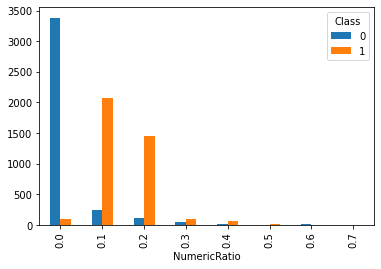

In [84]:
clf = MLPClassifier(max_iter=500)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.4, random_state=42)

stages = [("scaler", StandardScaler()), ("feature_selection", SelectKBest(k=5)), ("classifier", clf)]
pipeline = Pipeline(stages)

pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

selector = SelectKBest(k=5)
selector.fit(X_train, y_train)
X.columns.values[selector.get_support()]

pd.crosstab(balanced["NumericRatio"], balanced["Class"]).plot.bar()
#pipeline.score(X_test, y_test)


Note: For the above estimator the MLP hyperparameters were left as their default values. Using hyperparameter search methods the model could potentially be further improved.

### Visualizations

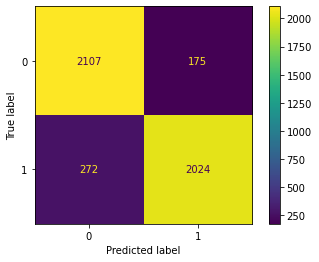

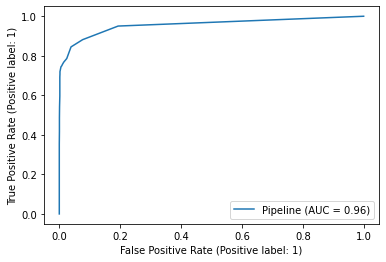

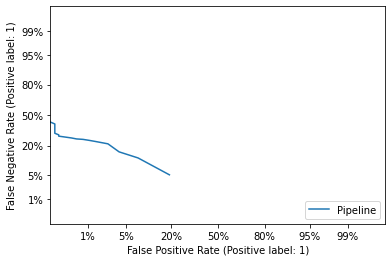

In [60]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, DetCurveDisplay

ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test)

RocCurveDisplay.from_estimator(pipeline, X_test, y_test)

DetCurveDisplay.from_estimator(pipeline, X_test, y_test)